# Rabies Classification Project ML approach

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
import glob
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/dataset'
pos_path = f'{dataset_path}/positif'
neg_path = f'{dataset_path}/negatif'

output_base = '/content/drive/MyDrive/rabies'
output_pos = os.path.join(output_base, 'positif')
output_neg = os.path.join(output_base, 'negatif')

#  Feature Extraction Justification – Rabies Cell Classification

In this project, we classify cell images as **positive** (fluorescent) or **negative** (non-fluorescent). The main difference is the presence of **fluorescence** in positive cells, which introduces distinct patterns in **brightness**, **texture**, and **shape**.

We extract the following features:

---

### 1. `extract_hog_features` – Histogram of Oriented Gradients (HOG)
- **Purpose:** Captures the **edge structure** and **shapes** within the image.
- **Why it helps:** Fluorescent (positive) cells often have **stronger contours** and more defined boundaries due to light emission.
- **Usefulness:** Detects differences in **cell outlines** and **internal structures**.

---

### 2. `extract_lbp_features` – Local Binary Patterns (LBP)
- **Purpose:** Captures **local texture** by comparing neighboring pixel intensities.
- **Why it helps:** Fluorescence introduces **textural granularity** in positive cells, which LBP effectively detects.
- **Usefulness:** Differentiates **smooth negative cells** from **textured positive cells**.

---

### 3. `extract_color_histogram` – RGB Intensity Histogram
- **Purpose:** Measures the distribution of **color intensities** across R, G, and B channels.
- **Why it helps:** Fluorescent cells are typically **brighter** and have **higher intensity values**.
- **Usefulness:** Captures **overall brightness** and **color variation**, crucial for detecting fluorescence.

---

###  Combined: `extract_all_features`
- **Why combine them?** Each feature type captures a different aspect:
  - **HOG** → Shape & edges
  - **LBP** → Texture
  - **Color histogram** → Brightness & color
- **Goal:** Create a **robust and discriminative feature vector** to distinguish positive from negative cells.

---

>  These features are carefully chosen to reflect the **visual effects of fluorescence**, the key factor differentiating positive from negative rabies cell images.


In [4]:
# Feature Extraction (same as before)
def extract_hog_features(image, pixels_per_cell=(16, 16)):
    gray = np.array(image.convert('L'))
    return hog(gray, pixels_per_cell=pixels_per_cell, cells_per_block=(2, 2), visualize=False)

def extract_lbp_features(image, radius=3, n_points=24):
    gray = np.array(image.convert('L'))
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist.astype("float") / (hist.sum() + 1e-6)

def extract_color_histogram(image, bins=32):
    channels = image.split()
    return np.concatenate([np.histogram(np.array(chan), bins=bins, range=(0, 256))[0] for chan in channels])

def extract_all_features(image):
    return np.hstack([
        extract_hog_features(image),
        extract_lbp_features(image),
        extract_color_histogram(image)
    ])

In [5]:
# Dataset Preparation
def prepare_dataset(data_dir):
    features, labels = [], []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    for label, class_name in enumerate(class_names):
        print(f"Processing {class_name}...")
        class_dir = os.path.join(data_dir, class_name)

        for img_file in tqdm(os.listdir(class_dir)):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    image = Image.open(os.path.join(class_dir, img_file)).convert('RGB').resize((224, 224))
                    features.append(extract_all_features(image))
                    labels.append(label)
                except Exception as e:
                    print(f"Skipping {img_file}: {str(e)}")

    return np.array(features), np.array(labels), class_names

#  Machine Learning Pipeline for Rabies Cell Classification

This script trains and evaluates multiple machine learning models to classify **rabies-infected cells** as **positive (fluorescent)** or **negative**.

---

##  Pipeline Components

### 1. `plot_learning_curves(models, X_train, y_train)`
- **Purpose:** Visualize model performance as the training set size increases.
- **Why:** Helps detect issues like **overfitting** (high train, low val) or **underfitting** (both low).
- **Output:** A grid of learning curve plots (Training vs. Validation Accuracy) for:
  - Random Forest
  - SVM
  - Logistic Regression
  - Gradient Boosting

---

### 2. `run_ml_pipeline(train_dir, test_dir)`
This is the **main pipeline function**:
-  **Loads and prepares data** from `train_dir` and `test_dir`
-  **Defines four classification models** in a dictionary:
  - `RandomForestClassifier`
  - `SVC` (Support Vector Machine)
  - `LogisticRegression`
  - `GradientBoostingClassifier`
-  Each model is wrapped in a `Pipeline` with `StandardScaler` for feature normalization.

---

###  What It Does Step by Step:

1. **Data Loading:**
   - Extracts features and labels from training and test image directories.

2. **Learning Curve Generation:**
   - Uses `learning_curve` to evaluate how models learn with increasing data.
   - Plots training and validation accuracy curves.

3. **Model Training and Evaluation:**
   - Trains each model on the full training set.
   - Predicts on the test set.
   - Calculates:
     - **Accuracy**
     - **AUC** (for binary classification)
     - **Confusion Matrix**
     - **Classification Report** (Precision, Recall, F1-score)

4. **Final Report:**
   - Prints metrics for all models for easy comparison.

---

>  This pipeline helps determine which model generalizes best for **fluorescence-based cell classification**, and provides a solid baseline before applying more advanced techniques (e.g., deep learning).


In [6]:
# Plot Learning Curves
def plot_learning_curves(models, X_train, y_train):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for i, (name, model) in enumerate(models.items()):
        print(f"Generating learning curve for {name}...")

        # Generate learning curve
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train,
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=5, scoring='accuracy', n_jobs=-1
        )

        # Calculate means and stds
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        # Plot
        axes[i].plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
        axes[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

        axes[i].plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
        axes[i].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

        axes[i].set_title(f'{name} Learning Curve')
        axes[i].set_xlabel('Training Set Size')
        axes[i].set_ylabel('Accuracy Score')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(0.5, 1.05)

    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Model Training and Evaluation
def run_ml_pipeline(train_dir, test_dir):
    print("=== Loading Data ===")
    X_train, y_train, classes = prepare_dataset(train_dir)
    X_test, y_test, _ = prepare_dataset(test_dir)

    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")

    print("\n=== Setting up Models ===")
    models = {
        'RandomForest': Pipeline([('scaler', StandardScaler()),
                                ('model', RandomForestClassifier(n_estimators=200, max_depth=10,
                                                               class_weight='balanced', random_state=42))]),
        'SVM': Pipeline([('scaler', StandardScaler()),
                        ('model', SVC(kernel='rbf', C=10, probability=True,
                                    class_weight='balanced', random_state=42))]),
        'LogisticRegression': Pipeline([('scaler', StandardScaler()),
                                       ('model', LogisticRegression(max_iter=1000,
                                                                  class_weight='balanced',
                                                                  random_state=42))]),
        'GradientBoosting': Pipeline([('scaler', StandardScaler()),
                                     ('model', GradientBoostingClassifier(n_estimators=100,
                                                                        learning_rate=0.1,
                                                                        max_depth=5,
                                                                        random_state=42))])
    }

    # Generate Learning Curves
    print("\n=== Generating Learning Curves ===")
    plot_learning_curves(models, X_train, y_train)

    print("\n=== Training Models ===")
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Evaluation
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba) if (len(classes) == 2 and y_proba is not None) else None

        results[name] = {
            'accuracy': acc,
            'auc': auc,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, y_pred, target_names=classes)
        }

    # Print results
    print("\n=== Final Results ===")
    for name, metrics in results.items():
        print(f"\nModel: {name}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        if metrics['auc'] is not None:
            print(f"AUC: {metrics['auc']:.4f}")
        print("\nConfusion Matrix:")
        print(metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(metrics['classification_report'])
        print("="*50)



=== Loading Data ===
Processing negatif...


100%|██████████| 18/18 [00:11<00:00,  1.58it/s]


Processing positif...


100%|██████████| 58/58 [00:36<00:00,  1.59it/s]


Processing negatif...


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


Processing positif...


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]

Training samples: 76
Test samples: 33

=== Setting up Models ===

=== Generating Learning Curves ===
Generating learning curve for RandomForest...


Generating learning curve for SVM...
Generating learning curve for LogisticRegression...
Generating learning curve for GradientBoosting...


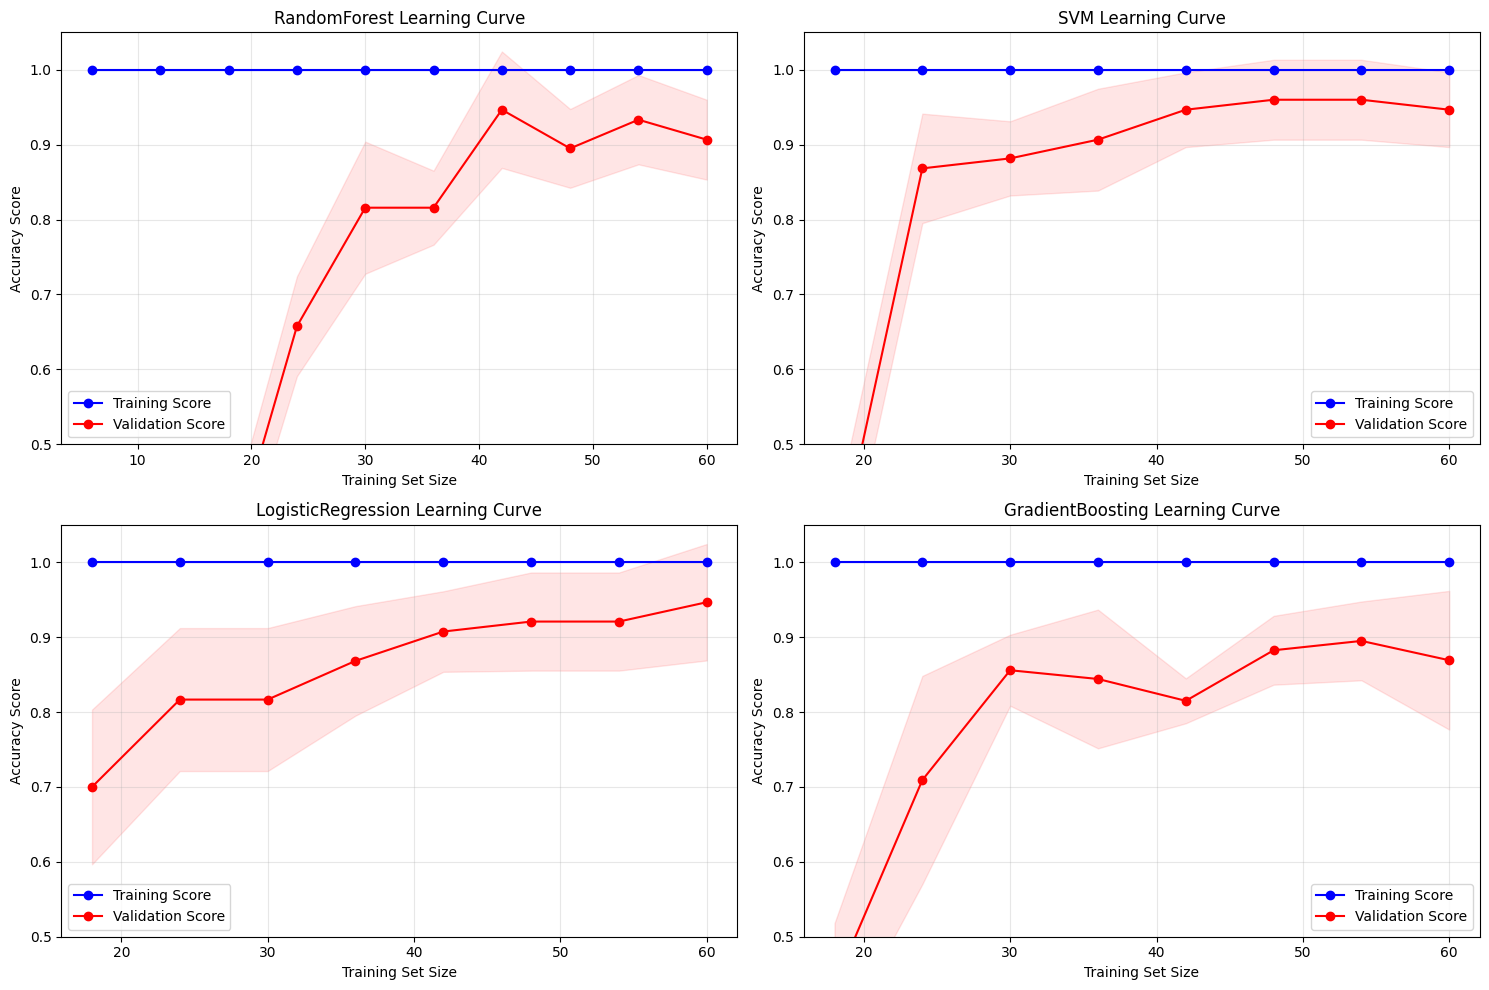


=== Training Models ===

Training RandomForest...

Training SVM...

Training LogisticRegression...

Training GradientBoosting...

=== Final Results ===

Model: RandomForest
Accuracy: 1.0000
AUC: 1.0000

Confusion Matrix:
[[ 8  0]
 [ 0 25]]

Classification Report:
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         8
     positif       1.00      1.00      1.00        25

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33


Model: SVM
Accuracy: 1.0000
AUC: 1.0000

Confusion Matrix:
[[ 8  0]
 [ 0 25]]

Classification Report:
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         8
     positif       1.00      1.00      1.00        25

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00

In [7]:
# Example usage
if __name__ == "__main__":
    train_dir = '/content/drive/MyDrive/data_split/train'  # Update with your path
    test_dir = '/content/drive/MyDrive/data_split/test'    # Update with your path
    run_ml_pipeline(train_dir, test_dir)

#  Learning Curve Analysis – Model-by-Model Overview

This section analyzes the learning curves for each model to detect signs of **overfitting** or **underfitting**.

---

##  1. Random Forest
- **Training Score:** Constantly at **1.0** → model perfectly memorizes training data.
- **Validation Score:** Starts low (~0.6), increases with more data but **remains below training**, with some fluctuation.
- ** Conclusion:** **Clear overfitting** – the model learns training data too well but struggles to generalize, especially with small sample sizes.

---

##  2. SVM
- **Training Score:** Near **1.0**, slightly decreasing with more data.
- **Validation Score:** Improves steadily and gets **closer to training**.
- ** Conclusion:** **Moderate overfitting**, but shows **much better generalization** than Random Forest. The gap reduces as training size increases, suggesting it benefits from more data.

---

##  3. Logistic Regression
- **Training Score:** Constantly at **1.0**.
- **Validation Score:** Starts low, improves steadily, and becomes **close to training**.
- ** Conclusion:** **Slight overfitting**, but overall shows **good generalization**. A simple model that handles small datasets well.

---

##  4. Gradient Boosting
- **Training Score:** Always at **1.0**.
- **Validation Score:** Fluctuates, unstable with training size changes. Gap between training and validation **persists**.
- ** Conclusion:** **High variance / overfitting** – the model is very sensitive to small data and lacks stability in generalization.

---

##  Summary

| Model              | Overfitting Risk | Generalization Stability |
|-------------------|------------------|---------------------------|
| Random Forest      | 🔴 High          | 🚫 Poor generalization    |
| Gradient Boosting  | 🔴 High          | ⚠️ Unstable                |
| SVM                | 🟡 Moderate      | ✅ Improves with data     |
| Logistic Regression| 🟢 Low           | ✅ Good generalization    |

>  All models show **some overfitting**, but **Random Forest and Gradient Boosting** are the most affected. **SVM and Logistic Regression** perform more stably with increasing data.


#  Why Transfer Learning is a Better Approach for Rabies Cell Classification

Given the signs of **overfitting** observed in all traditional machine learning models (especially Random Forest and Gradient Boosting), we recommend switching to a **transfer learning** approach using deep learning.

---

##  Limitations of Classical ML Models

- All models achieve perfect accuracy on the test set, but learning curves show clear **overfitting**, especially with small training data.
- Traditional models rely on hand-crafted features (HOG, LBP, color histogram), which may not capture complex **fluorescent patterns** effectively.
- Small datasets make classical models prone to memorization rather than generalization.

---

##  Advantages of Transfer Learning

### 1. **Leverages Pretrained Knowledge**
- Uses powerful CNN architectures like **ResNet**, **EfficientNet**, or **MobileNet**, pretrained on **millions of images** (e.g., ImageNet).
- These models already understand basic visual patterns (edges, textures, colors), which are also useful in microscopy.

### 2. **Requires Less Data**
- With **frozen base layers**, only the final classification head is fine-tuned on your rabies dataset.
- Prevents overfitting by drastically reducing the number of trainable parameters.

### 3. **Captures Fluorescence Features**
- Deep layers learn **subtle differences in brightness, texture, and patterns** caused by fluorescence.
- More powerful than handcrafted features like HOG or LBP.

### 4. **Better Generalization**
- Transfer learning models typically show **more stable training** and **better validation performance**, even with limited data.
- Techniques like **data augmentation**, **early stopping**, and **regularization** further improve robustness.

---

##  Summary

| Approach           | Pros                                    | Cons                                |
|--------------------|-----------------------------------------|-------------------------------------|
| Classical ML        | Simple, fast on small datasets          | Overfits easily, limited feature power |
| Transfer Learning   | Powerful, generalizes better, learns deep features | Requires GPU, more setup time      |

>  **Conclusion:** Transfer learning is more suitable for your problem. It reduces overfitting, improves generalization, and better captures the complex visual differences caused by rabies-related fluorescence.

